In [1]:
import os 
from Bio import SeqIO
import pickle
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import math

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [4]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 10
expName = "Test_Run_current_setting1"
outPath = "Generated"
foldName = "folds.pickle"

modelNames = ["DLNN_3", "DLNN_5"]

epochs = 200
batch_size = 64
shuffle = False
seed = None

dataset_path = "CORENup-Datasets\\Datasets"
setting = "Setting1"


In [5]:
##################################################################################
##### Checking the directory
##################################################################################

dataset_setting_path = os.path.join(dataset_path, setting)
dataset_varieties = next(os.walk(dataset_setting_path))
print(dataset_varieties)

('CORENup-Datasets\\Datasets\\Setting1', ['Drosophila', 'Elegans', 'Homo_Sapiens', 'Yeast'], [])


In [6]:
##################################################################################
##### define custom one hot encoding, contains code from repository
##################################################################################

def one_hot_encode(sequence):
    
    seq_encoded = np.zeros((len(sequence),4))
    dict_nuc = {
        "A": 0,
        "C": 1,
        "G": 2,
        "T":3
    }
    i = 0
    
    for single_character in sequence:
        if(single_character.upper() in dict_nuc.keys()):
            seq_encoded[i][dict_nuc[single_character.upper()]] = 1
            i = i+1
        else:
            return []
    
    return seq_encoded

In [7]:
##################################################################################
##### Function to customize the DLNN network architecture with parameters
##################################################################################

def Conv_LSTM_DLNN(input_shape=(150,4), conv_filters_per_layer = 50, kernel_length = 5, lstm_decode_units = 50, 
                   learn_rate = 0.0003, prob = 0.5, loss = 'binary_crossentropy', metrics = None, max_pool_width = 2, 
                   max_pool_stride = 2, dense_decode_units = 150):
        
    beta = 0.001

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(conv_filters_per_layer, kernel_length, input_shape = input_shape, 
                                     kernel_regularizer=tf.keras.regularizers.l2(beta), padding="same"))

    model.add(tf.keras.layers.MaxPool1D(pool_size = max_pool_width, strides = max_pool_stride))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(beta)))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras .layers.Flatten())

    model.add(tf.keras.layers.Dense(dense_decode_units, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='relu'))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='sigmoid'))
    
    #[tf.keras.metrics.binary_accuracy, metrics.precision, metrics.recall, metrics.f1score])
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss, metrics = metrics) 
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)

    return model

In [16]:
model = Conv_LSTM_DLNN(input_shape = (150, 4), conv_filters_per_layer = 50, kernel_length = 5, lstm_decode_units = 50,
                       learn_rate = 0.0003, prob = 0.5, loss='binary_crossentropy', metrics=None)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 150, 50)           1050      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 75, 50)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 75, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 75, 50)            20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 75, 50)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3750)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)              

In [9]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

In [7]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Kernel_Length" : [],
    "Dataset" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        
        current_dataset_variety = root.split("\\")[len(root.split("\\"))-1]
        
        ##################################################################################
        ##### read the current file
        ##################################################################################
        
        openFile = open(os.path.join(root, file))
        fastaSequences = SeqIO.parse(openFile, "fasta")
        
        ##################################################################################
        ##### extract data from the current fasta file
        ##################################################################################
        
        nucleosomal_List = []
        linker_List = []
        nucleosomal_onehotencoded_List = []
        linker_onehotencoded_List = []
        
        for fasta in fastaSequences: 
            name, sequence = fasta.id, str(fasta.seq)
            if "nucleosomal" in name:
                nucleosomal_List.append(sequence)
                aus_seq = one_hot_encode(sequence)
                if(len(aus_seq) != 0):
                    nucleosomal_onehotencoded_List.append(aus_seq)
            else:
                linker_List.append(sequence)
                aus_seq = one_hot_encode(sequence)
                if(len(aus_seq) != 0):
                    linker_onehotencoded_List.append(aus_seq)
        
        print("\n======================================================================")
        print("\nFile: "+os.path.join(root, file))
        print("Nucleosomi: "+str(len(nucleosomal_onehotencoded_List)))
        print("Linker: "+str(len(linker_onehotencoded_List)))
        
        ##################################################################################
        ##### Generate Folds from dataset, and store to file
        ##################################################################################
        
        ## create the features and labels datasets for the training
        input_size = (len(nucleosomal_onehotencoded_List[1]), 4)
        labels = np.concatenate((np.ones((len(nucleosomal_onehotencoded_List), 1), dtype=np.float32), np.zeros((len(linker_onehotencoded_List), 1), dtype=np.float32)), axis=0)
        features = np.concatenate((nucleosomal_onehotencoded_List,linker_onehotencoded_List), 0)

        ## Generate the k-fold dataset
        folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
        
        ## Write the k-fold dataset to file
        foldPath = os.path.join(outPath, expName, current_dataset_variety, "{}fold".format(n_fold))
        if(not os.path.isdir(foldPath)):
            os.makedirs(foldPath)
        pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
        
        ##################################################################################
        ##### TRAIN and PREDICT for every Fold, using both models (DLNN3 and DLNN5)
        ##################################################################################
        
        for modelName in modelNames:
            
            kernel_length = int(modelName[-1])
            
            ## Create and set directory to save model
            modelPath = os.path.join(outPath, expName, current_dataset_variety, "{}fold".format(n_fold), "models", modelName)
            if(not os.path.isdir(modelPath)):
                os.makedirs(modelPath)
            
            # fold counter
            i = 0

            for fold in folds:
                
                print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")
                
                ## Generate model using function
                model = Conv_LSTM_DLNN(input_size = input_size, filters = 50, kernel_len = kernel_length, lstm_hidden_size = 50, 
                                    learn_rate = 0.0003, prob = 0.5, loss='binary_crossentropy', metrics=None)

                ## Define the model callbacks for early stopping and saving the model. Then train model
                modelCallbacks = [
                    tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_bestModel-fold{}.hdf5".format(modelName, i)),
                                                       monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                     mode = 'auto', baseline = None, restore_best_weights = False)
                ]
                model.fit(x = fold["X_train"], y = fold["y_train"], batch_size = batch_size, epochs = epochs, verbose = 0, 
                          callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))

                ##################################################################################
                ##### Prediction and metrics for TRAIN dataset
                ##################################################################################
                
                y_pred = model.predict(fold["X_train"])
                label_pred = pred2label(y_pred)
                # Compute precision, recall, sensitivity, specifity, mcc
                acc = accuracy_score(fold["y_train"], label_pred)
                prec = precision_score(fold["y_train"],label_pred)

                conf = confusion_matrix(fold["y_train"], label_pred)
                if(conf[0][0]+conf[1][0]):
                    sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                else:
                    sens = 0.0
                if(conf[1][1]+conf[0][1]):
                    spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                else:
                    spec = 0.0
                if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                    mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                else:
                    mcc= 0.0
                fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                auc = roc_auc_score(fold["y_train"], y_pred)

                evaluations["Model"].append(modelName)
                evaluations["Kernel_Length"].append(kernel_length)
                evaluations["Dataset"].append(current_dataset_variety)
                evaluations["Fold"].append(i)
                evaluations["Train_Test"].append("Train")
                evaluations["Accuracy"].append(acc)
                evaluations["Precision"].append(prec)
                evaluations["TPR"].append(tpr)
                evaluations["FPR"].append(fpr)
                evaluations["TPR_FPR_Thresholds"].append(thresholds)
                evaluations["AUC"].append(auc)
                evaluations["Sensitivity"].append(sens)
                evaluations["Specificity"].append(spec)
                evaluations["MCC"].append(mcc)

                ##################################################################################
                ##### Prediction and metrics for TEST dataset
                ##################################################################################

                y_pred = model.predict(fold["X_test"])
                label_pred = pred2label(y_pred)
                # Compute precision, recall, sensitivity, specifity, mcc
                acc = accuracy_score(fold["y_test"], label_pred)
                prec = precision_score(fold["y_test"],label_pred)

                conf = confusion_matrix(fold["y_test"], label_pred)
                if(conf[0][0]+conf[1][0]):
                    sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                else:
                    sens = 0.0
                if(conf[1][1]+conf[0][1]):
                    spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                else:
                    spec = 0.0
                if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                    mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                else:
                    mcc= 0.0
                fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                auc = roc_auc_score(fold["y_test"], y_pred)
                
                evaluations["Model"].append(modelName)
                evaluations["Kernel_Length"].append(kernel_length)
                evaluations["Dataset"].append(current_dataset_variety)
                evaluations["Fold"].append(i)
                evaluations["Train_Test"].append("Test")
                evaluations["Accuracy"].append(acc)
                evaluations["Precision"].append(prec)
                evaluations["TPR"].append(tpr)
                evaluations["FPR"].append(fpr)
                evaluations["TPR_FPR_Thresholds"].append(thresholds)
                evaluations["AUC"].append(auc)
                evaluations["Sensitivity"].append(sens)
                evaluations["Specificity"].append(spec)
                evaluations["MCC"].append(mcc)

                i = i+1
                del model
                tf.keras.backend.clear_session()

##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations.pickle".format(n_fold)), "wb"))




File: CORENup-Datasets\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster.fas
Nucleosomi: 2900
Linker: 2850

Train/Test model DLNN_3 on Fold #0.

Train/Test model DLNN_3 on Fold #1.

Train/Test model DLNN_3 on Fold #2.

Train/Test model DLNN_3 on Fold #3.

Train/Test model DLNN_3 on Fold #4.

Train/Test model DLNN_3 on Fold #5.

Train/Test model DLNN_3 on Fold #6.

Train/Test model DLNN_3 on Fold #7.

Train/Test model DLNN_3 on Fold #8.

Train/Test model DLNN_3 on Fold #9.

Train/Test model DLNN_5 on Fold #0.

Train/Test model DLNN_5 on Fold #1.

Train/Test model DLNN_5 on Fold #2.

Train/Test model DLNN_5 on Fold #3.

Train/Test model DLNN_5 on Fold #4.

Train/Test model DLNN_5 on Fold #5.

Train/Test model DLNN_5 on Fold #6.

Train/Test model DLNN_5 on Fold #7.

Train/Test model DLNN_5 on Fold #8.

Train/Test model DLNN_5 on Fold #9.


File: CORENup-Datasets\Datasets\Setting1\Elegans\nucleosomes_vs_linkers_elegans.fas
Nucleosomi: 2567
Linker: 2608

Train/Test model DL

## Visualization of Evaluation

In [5]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd


In [9]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations.pickle".format(n_fold)), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [10]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset", 
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

DLNN_3 = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(1), ['DLNN_3'])]
DLNN_5 = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(1), ['DLNN_5'])]

DLNN_3_Train = DLNN_3[np.in1d(DLNN_3.index.get_level_values(2), ['Train'])]
DLNN_3_Test = DLNN_3[np.in1d(DLNN_3.index.get_level_values(2), ['Test'])]

DLNN_5_Train = DLNN_5[np.in1d(DLNN_5.index.get_level_values(2), ['Train'])]
DLNN_5_Test = DLNN_5[np.in1d(DLNN_5.index.get_level_values(2), ['Test'])]

In [11]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ")
print(list(evaluations_df_grouped.columns))

Metrics Available : 
['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [12]:
metric_to_plot = "Accuracy"

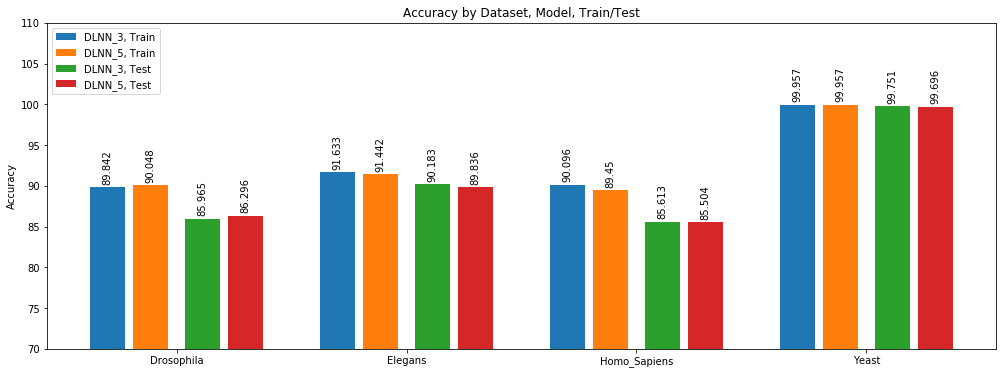

In [13]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(DLNN_3_Train[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(x - (4*(width/2)), round(DLNN_3_Train[metric_to_plot]*100, 3), width, label='DLNN_3, Train')
rects2 = ax.bar(x - (1.5*(width/2)), round(DLNN_5_Train[metric_to_plot]*100, 3), width, label='DLNN_5, Train')
rects3 = ax.bar(x + (1.5*(width/2)), round(DLNN_3_Test[metric_to_plot]*100, 3), width, label='DLNN_3, Test')
rects4 = ax.bar(x + (4*(width/2)), round(DLNN_5_Test[metric_to_plot]*100, 3), width, label='DLNN_5, Test')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
            (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
# ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
# ax.set_xticklabels([m+" - "+str(n) for m,n in 
#                         zip(DLNN_3_Train.index.get_level_values(0),DLNN_3_Train.index.get_level_values(1))],
#                   rotation=30)
ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))

ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()

### Store all metrics' plots to file

In [18]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    x = np.arange(len(DLNN_3_Train[metric_to_plot]))
    width = 0.15

    fig, ax = plt.subplots(figsize=(17,6))
    rects1 = ax.bar(x - (4*(width/2)), round(DLNN_3_Train[metric_to_plot]*100, 3), width, label='DLNN_3, Train')
    rects2 = ax.bar(x - (1.5*(width/2)), round(DLNN_5_Train[metric_to_plot]*100, 3), width, label='DLNN_5, Train')
    rects3 = ax.bar(x + (1.5*(width/2)), round(DLNN_3_Test[metric_to_plot]*100, 3), width, label='DLNN_3, Test')
    rects4 = ax.bar(x + (4*(width/2)), round(DLNN_5_Test[metric_to_plot]*100, 3), width, label='DLNN_5, Test')

    ## Custom y-axis tick labels
    ax.set_ylabel(metric_to_plot)
    ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
                (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
    # ax.set_ylim([80, 105])

    ## Custom x-axis tick labels
    ax.set_xticks(x)
    # ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
    # ax.set_xticklabels([m+" - "+str(n) for m,n in 
    #                         zip(DLNN_3_Train.index.get_level_values(0),DLNN_3_Train.index.get_level_values(1))],
    #                   rotation=30)
    ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))

    ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
    ax.legend(loc='upper left')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", 
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    
    plt.savefig(os.path.join(evalPath, "{}_DLNN_Comparison".format(metric_to_plot)))
    plt.close()
    